# Home Credit Default Risk
## Can you predict how capable each applicant is of repaying a loan?
Kaggle page: https://www.kaggle.com/c/home-credit-default-risk#description

**Description**

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

**Evaluation**

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
For each SK_ID_CURR in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:

    SK_ID_CURR,TARGET
    100001,0.1
    100005,0.9
    100013,0.2
    etc.

- **application_{train|test}.csv**
 - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
 - Static data for all applications. One row represents one loan in our data sample.

- **bureau.csv**
 - All client\u0027s previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
 - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

- **bureau_balance.csv**
 - Monthly balances of previous credits in Credit Bureau.
 - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

- **POS_CASH_balance.csv**
 - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
 - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

- **credit_card_balance.csv**
 - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
 - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

- **previous_application.csv**
 - All previous applications for Home Credit loans of clients who have loans in our sample.
 - There is one row for each previous application related to loans in our data sample.

- **installments_payments.csv**
 - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
 - There is a) one row for every payment that was made plus b) one row each for missed payment.
 - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

- **HomeCredit_columns_description.csv**
 - This file contains descriptions for the columns in the various data files.

![Logical Schema](home_credit.png)

In [2]:
import os
import re
import datetime as dt
from time import time
import math
import random

# data science
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import randint as sp_randint

# data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# machine learning
from sklearn.preprocessing import StandardScaler, Imputer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [3]:
# configurations

# style for data visualizations
plt.style.use('fivethirtyeight')
%matplotlib inline
sns.set()

# Allow multiple outputs for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# display all columns
pd.set_option('display.max_columns', None)

# suppress auto-conversion to scientific notation
pd.set_option('display.precision', 6)

In [4]:
# all data sources provided
os.listdir('input/')

['application_test.csv',
 '.DS_Store',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'checkpoint1.feather',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [5]:
for file in sorted(os.listdir('input/')):
    print(f"pd.read_csv('input/{file}')")

pd.read_csv('input/.DS_Store')
pd.read_csv('input/POS_CASH_balance.csv')
pd.read_csv('input/application_test.csv')
pd.read_csv('input/application_train.csv')
pd.read_csv('input/bureau.csv')
pd.read_csv('input/bureau_balance.csv')
pd.read_csv('input/checkpoint1.feather')
pd.read_csv('input/credit_card_balance.csv')
pd.read_csv('input/installments_payments.csv')
pd.read_csv('input/previous_application.csv')
pd.read_csv('input/sample_submission.csv')


# Checkpoint1

In [6]:
# test = pd.read_csv('input/application_test.csv')
# train = pd.read_csv('input/application_train.csv')
df = pd.read_feather('input/checkpoint1.feather')
description = pd.read_excel('HomeCredit_columns_description.xlsx')

In [7]:
# inst_pmts = pd.read_csv('input/installments_payments.csv')
# prev_app = pd.read_csv('input/previous_application.csv')
# poscash_balance= pd.read_csv('input/POS_CASH_balance.csv')
# ccard_balance = pd.read_csv('input/credit_card_balance.csv')
bureau_balance = pd.read_csv('input/bureau_balance.csv')
bureau = pd.read_csv('input/bureau.csv')

# Adding more data

In [92]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [93]:
bureau.describe(include='all')

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,NaN,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04


In [94]:
bureau.isnull().sum()
bureau.info()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [95]:
len(df)
len(bureau)

356255

1716428

In [96]:
bureau.set_index(['SK_ID_CURR','SK_ID_BUREAU']).sort_index()

CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
SK_ID_CURR SK_ID_BUREAU                                              
100001     5896630             Closed      currency 1         -857   
           5896631             Closed      currency 1         -909   
           5896632             Closed      currency 1         -879   
           5896633             Closed      currency 1        -1572   
           5896634             Active      currency 1         -559   
           5896635             Active      currency 1          -49   
           5896636             Active      currency 1         -320   
100002     6113835             Closed      currency 1        -1043   
           6158903             Active      currency 1        -1042   
           6158904             Closed      currency 1        -1125   
           6158905             Closed      currency 1         -476   
           6158906             Closed      currency 1        -1437   
           6158907             Closed      currency 1        -1121   
           6158908             Closed      currency 1         -645   
           6158909             Active      currency 1         -103   
100003     5885877             Closed      currency 1        -2586   
           5885878             Closed      currency 1        -1636   
           5885879             Closed      currency 1         -775   
           5885880             Active      currency 1         -606   
100004     6829133             Closed      currency 1        -1326   
           6829134             Closed      currency 1         -408   
100005     6735200             Closed      currency 1         -373   
           6735201             Active      currency 1         -137   
           6735202             Active      currency 1          -62   
100007     5987200             Closed      currency 1        -1149   
100008     6491432             Closed      currency 1        -1097   
           6491433             Closed      currency 1        -1097   
           6491434             Active      currency 1          -78   
100009     5650996             Closed      currency 1         -684   
           5650997             Closed      currency 1         -782   
...                               ...             ...          ...   
456249     5371696             Closed      currency 1        -1454   
           5371697             Closed      currency 1        -2050   
           5371698             Closed      currency 1        -1912   
           5371699             Closed      currency 1        -2049   
           5371700             Closed      currency 1        -1911   
           5371701             Closed      currency 1        -1490   
           5371702             Closed      currency 1        -1250   
           5371703             Closed      currency 1        -1165   
           5371704             Active      currency 1         -483   
           5371705             Closed      currency 1        -1680   
           5371706             Closed      currency 1         -903   
456250     6817236             Closed      currency 1        -1002   
           6817237             Active      currency 1         -760   
           6817238             Active      currency 1         -824   
456253     5113039             Active      currency 1         -919   
           6098498             Closed      currency 1         -919   
           6098499             Closed      currency 1         -919   
           6230038             Active      currency 1         -713   
456254     6669849             Closed      currency 1        -1104   
456255     5126327             Closed      currency 1        -1022   
           5126328             Closed      currency 1         -970   
           5126329             Active      currency 1         -573   
           5126330             Closed      currency 1        -1021   
           5126331             Active      currency 1        -1020   
           5126332             Act

In [108]:
df[df['SK_ID_CURR'] == 100002]
bureau[bureau['SK_ID_CURR'] == 100002]

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH_x,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1_x,EXT_SOURCE_2_x,EXT_SOURCE_3_x,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Securit

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
675684,100002,6158904,Closed,currency 1,-1125,0,-1038.0,-1038.0,NaN,0,40761.000,NaN,NaN,0.0,Credit card,-1038,0.0
675685,100002,6158905,Closed,currency 1,-476,0,NaN,-48.0,NaN,0,0.000,0.0,NaN,0.0,Credit card,-47,NaN
675686,100002,6158906,Closed,currency 1,-1437,0,-1072.0,-1185.0,0.000,0,135000.000,0.0,0.000,0.0,Consumer credit,-1185,0.0
675687,100002,6158907,Closed,currency 1,-1121,0,-911.0,-911.0,3321.000,0,19071.000,NaN,NaN,0.0,Consumer credit,-906,0.0
675688,100002,6158908,Closed,currency 1,-645,0,85.0,-36.0,5043.645,0,120735.000,0.0,0.000,0.0,Consumer credit,-34,0.0
675689,100002,6158909,Active,currency 1,-103,0,NaN,NaN,40.500,0,31988.565,0.0,31988.565,0.0,Credit card,-24,0.0
1337779,100002,6158903,Active,currency 1,-1042,0,780.0,NaN,NaN,0,450000.000,245781.0,0.000,0.0,Consumer credit,-7,0.0
1486113,100002,6113835,Closed,currency 1,-1043,0,62.0,-967.0,0.000,0,67500.000,NaN,NaN,0.0,Credit card,-758,0.0


In [75]:
bureau[bureau['SK_ID_CURR'] == 100001].groupby('SK_ID_CURR').sum()
description[description['Table'] == 'bureau.csv'].transpose()

,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
SK_ID_CURR,,,,,,,,,,,,,
100001,41276431,-5145,0,577.0,-3302.0,0.0,0,1453365.0,596686.5,0.0,0.0,-652,24817.5


,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141
Table,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv,bureau.csv
Row,SK_ID_CURR,SK_BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
Description,ID of loan in our sample - one loan in our sam...,Recoded ID of previous Credit Bureau credit re...,Status of the Credit Bureau (CB) reported credits,Recoded currency of the Credit Bureau credit,How many days before current application did c...,Number of days past due on CB credit at the ti...,Remaining duration of CB credit (in days) at t...,Days since CB credit ended at the time of appl...,Maximal amount overdue on the Credit Bureau cr...,How many times was the Credit Bureau credit pr...,Current credit amount for the Credit Bureau cr...,Current debt on Credit Bureau credit,Current credit limit of credit card reported i...,Current amount overdue on Credit Bureau credit,"Type of Credit Bureau credit (Car, cash,...)",How many days before loan application did last...,Annuity of the Credit Bureau credit
Special,hashed,hashed,NaN,recoded,time only relative to the application,NaN,time only relative to the application,time only relative to the application,NaN,NaN,NaN,NaN,NaN,NaN,NaN,time only relative to the application,NaN


In [168]:
grouped_bureau = bureau.groupby('SK_ID_CURR', as_index=False)
# group_sum = bureau.groupby('SK_ID_CURR', as_index=False).sum()
# group_max = bureau.groupby('SK_ID_CURR', as_index=False).max()
# group_mean = bureau.groupby('SK_ID_CURR', as_index=False).mean()

In [169]:
grouped_bureau.max().join(df['TARGET'],on='SK_ID_CURR',how='left').corr()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET
SK_ID_CURR,1.000000,0.000514,0.004285,0.000554,0.001773,0.001829,0.002190,-0.000529,0.001941,-0.001001,-0.001094,-0.000149,0.003499,-0.003023,-0.003707
SK_ID_BUREAU,0.000514,1.000000,0.015241,-0.006045,0.021706,0.021040,0.003423,0.002647,0.017672,0.016345,-0.004910,-0.001259,0.021604,0.006346,-0.001311
DAYS_CREDIT,0.004285,0.015241,1.000000,-0.008029,0.187909,0.554810,-0.018582,0.019912,0.073177,0.123903,0.052947,-0.005614,0.716567,0.014287,-0.000408
CREDIT_DAY_OVERDUE,0.000554,-0.006045,-0.008029,1.000000,-0.001632,-0.005953,0.001002,0.003198,-0.004864,-0.004723,0.007597,0.093753,-0.002124,-0.001236,0.000104
DAYS_CREDIT_ENDDATE,0.001773,0.021706,0.187909,-0.001632,1.000000,0.124811,-0.000667,0.150291,0.081217,0.088666,0.098545,0.001109,0.182620,0.008984,0.002434
DAYS_ENDDATE_FACT,0.001829,0.021040,0.554810,-0.005953,0.124811,1.000000,0.000375,0.032956,0.057656,0.053211,0.036635,0.001324,0.489004,0.013452,0.000409
AMT_CREDIT_MAX_OVERDUE,0.002190,0.003423,-0.018582,0.001002,-0.000667,0.000375,1.000000,0.003014,0.049635,0.002095,0.002349,0.008126,-0.001188,0.000683,-0.000142
CNT_CREDIT_PROLONG,-0.000529,0.002647,0.019912,0.003198,0.150291,0.032956,0.003014,1.000000,0.026807,0.020418,0.084372,0.001085,0.037748,0.001424,0.003670
AMT_CREDIT_SUM,0.001941,0.017672,0.073177,-0.004864,0.081217,0.057656,0.049635,0.026807,1.000000,0.595768,0.057299,0.005557,0.103108,0.054294,0.001481
AMT_CREDIT_SUM_DEBT,-0.001001,0.016345,0.123903,-0.004723,0.088666,0.053211,0.002095,0.020418,0.595768,1.000000,0.021412,0.007286,0.129336,0.048279,0.001424


In [162]:
group_max = group_max.join(df['TARGET'],on='SK_ID_CURR',how='left')

In [166]:
group_max.corr()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET
SK_ID_CURR,1.000000,0.000514,0.004285,0.000554,0.001773,0.001829,0.002190,-0.000529,0.001941,-0.001001,-0.001094,-0.000149,0.003499,-0.003023,-0.003707
SK_ID_BUREAU,0.000514,1.000000,0.015241,-0.006045,0.021706,0.021040,0.003423,0.002647,0.017672,0.016345,-0.004910,-0.001259,0.021604,0.006346,-0.001311
DAYS_CREDIT,0.004285,0.015241,1.000000,-0.008029,0.187909,0.554810,-0.018582,0.019912,0.073177,0.123903,0.052947,-0.005614,0.716567,0.014287,-0.000408
CREDIT_DAY_OVERDUE,0.000554,-0.006045,-0.008029,1.000000,-0.001632,-0.005953,0.001002,0.003198,-0.004864,-0.004723,0.007597,0.093753,-0.002124,-0.001236,0.000104
DAYS_CREDIT_ENDDATE,0.001773,0.021706,0.187909,-0.001632,1.000000,0.124811,-0.000667,0.150291,0.081217,0.088666,0.098545,0.001109,0.182620,0.008984,0.002434
DAYS_ENDDATE_FACT,0.001829,0.021040,0.554810,-0.005953,0.124811,1.000000,0.000375,0.032956,0.057656,0.053211,0.036635,0.001324,0.489004,0.013452,0.000409
AMT_CREDIT_MAX_OVERDUE,0.002190,0.003423,-0.018582,0.001002,-0.000667,0.000375,1.000000,0.003014,0.049635,0.002095,0.002349,0.008126,-0.001188,0.000683,-0.000142
CNT_CREDIT_PROLONG,-0.000529,0.002647,0.019912,0.003198,0.150291,0.032956,0.003014,1.000000,0.026807,0.020418,0.084372,0.001085,0.037748,0.001424,0.003670
AMT_CREDIT_SUM,0.001941,0.017672,0.073177,-0.004864,0.081217,0.057656,0.049635,0.026807,1.000000,0.595768,0.057299,0.005557,0.103108,0.054294,0.001481
AMT_CREDIT_SUM_DEBT,-0.001001,0.016345,0.123903,-0.004723,0.088666,0.053211,0.002095,0.020418,0.595768,1.000000,0.021412,0.007286,0.129336,0.048279,0.001424


In [100]:
# did not default
mask = np.logical_not(bureau2['SK_ID_CURR'].isin(df[df['TARGET'] == 1]['SK_ID_CURR']))
bureau2[mask].head()

# defaulted
bureau2[bureau2['SK_ID_CURR'].isin(df[df['TARGET'] == 1]['SK_ID_CURR'])].head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100001,41276431,-5145,0,577.0,-3302.0,0.0,0,1453365.0,596686.5,0.0,0.0,-652,24817.5
2,100003,23543514,-5603,0,-2178.0,-3292.0,0.0,0,1017400.5,0.0,810000.0,0.0,-3264,0.0
3,100004,13658267,-1734,0,-977.0,-1065.0,0.0,0,189037.8,0.0,0.0,0.0,-1064,0.0
4,100005,20205603,-572,0,1318.0,-123.0,0.0,0,657126.0,568408.5,0.0,0.0,-163,4261.5
5,100007,5987200,-1149,0,-783.0,-783.0,0.0,0,146250.0,0.0,0.0,0.0,-783,0.0


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1,100002,49226177,-6992,0,-2094.0,-4185.0,8405.145,0,865055.565,245781.0,31988.565,0.0,-3999,0.0
25,100031,43313648,-4057,0,2343.0,-1796.0,0.000,0,3970651.500,1125000.0,0.000,0.0,-1864,0.0
38,100047,26786870,-5524,0,6505.0,-1397.0,13518.675,0,9527634.000,3220456.5,0.000,0.0,-2223,0.0
40,100049,36713320,-5734,0,-703.0,-2023.0,0.000,0,851747.850,552442.5,8819.235,0.0,-2620,0.0
82,100096,6238780,-2922,0,-2610.0,-1647.0,0.000,0,65610.000,0.0,0.000,0.0,-1647,0.0


In [101]:
bureau3 = bureau2.join(df['TARGET'], on='SK_ID_CURR')
bureau3 = bureau3[((bureau3['TARGET'] == 0.0) | (bureau3['TARGET'] == 1.0))]

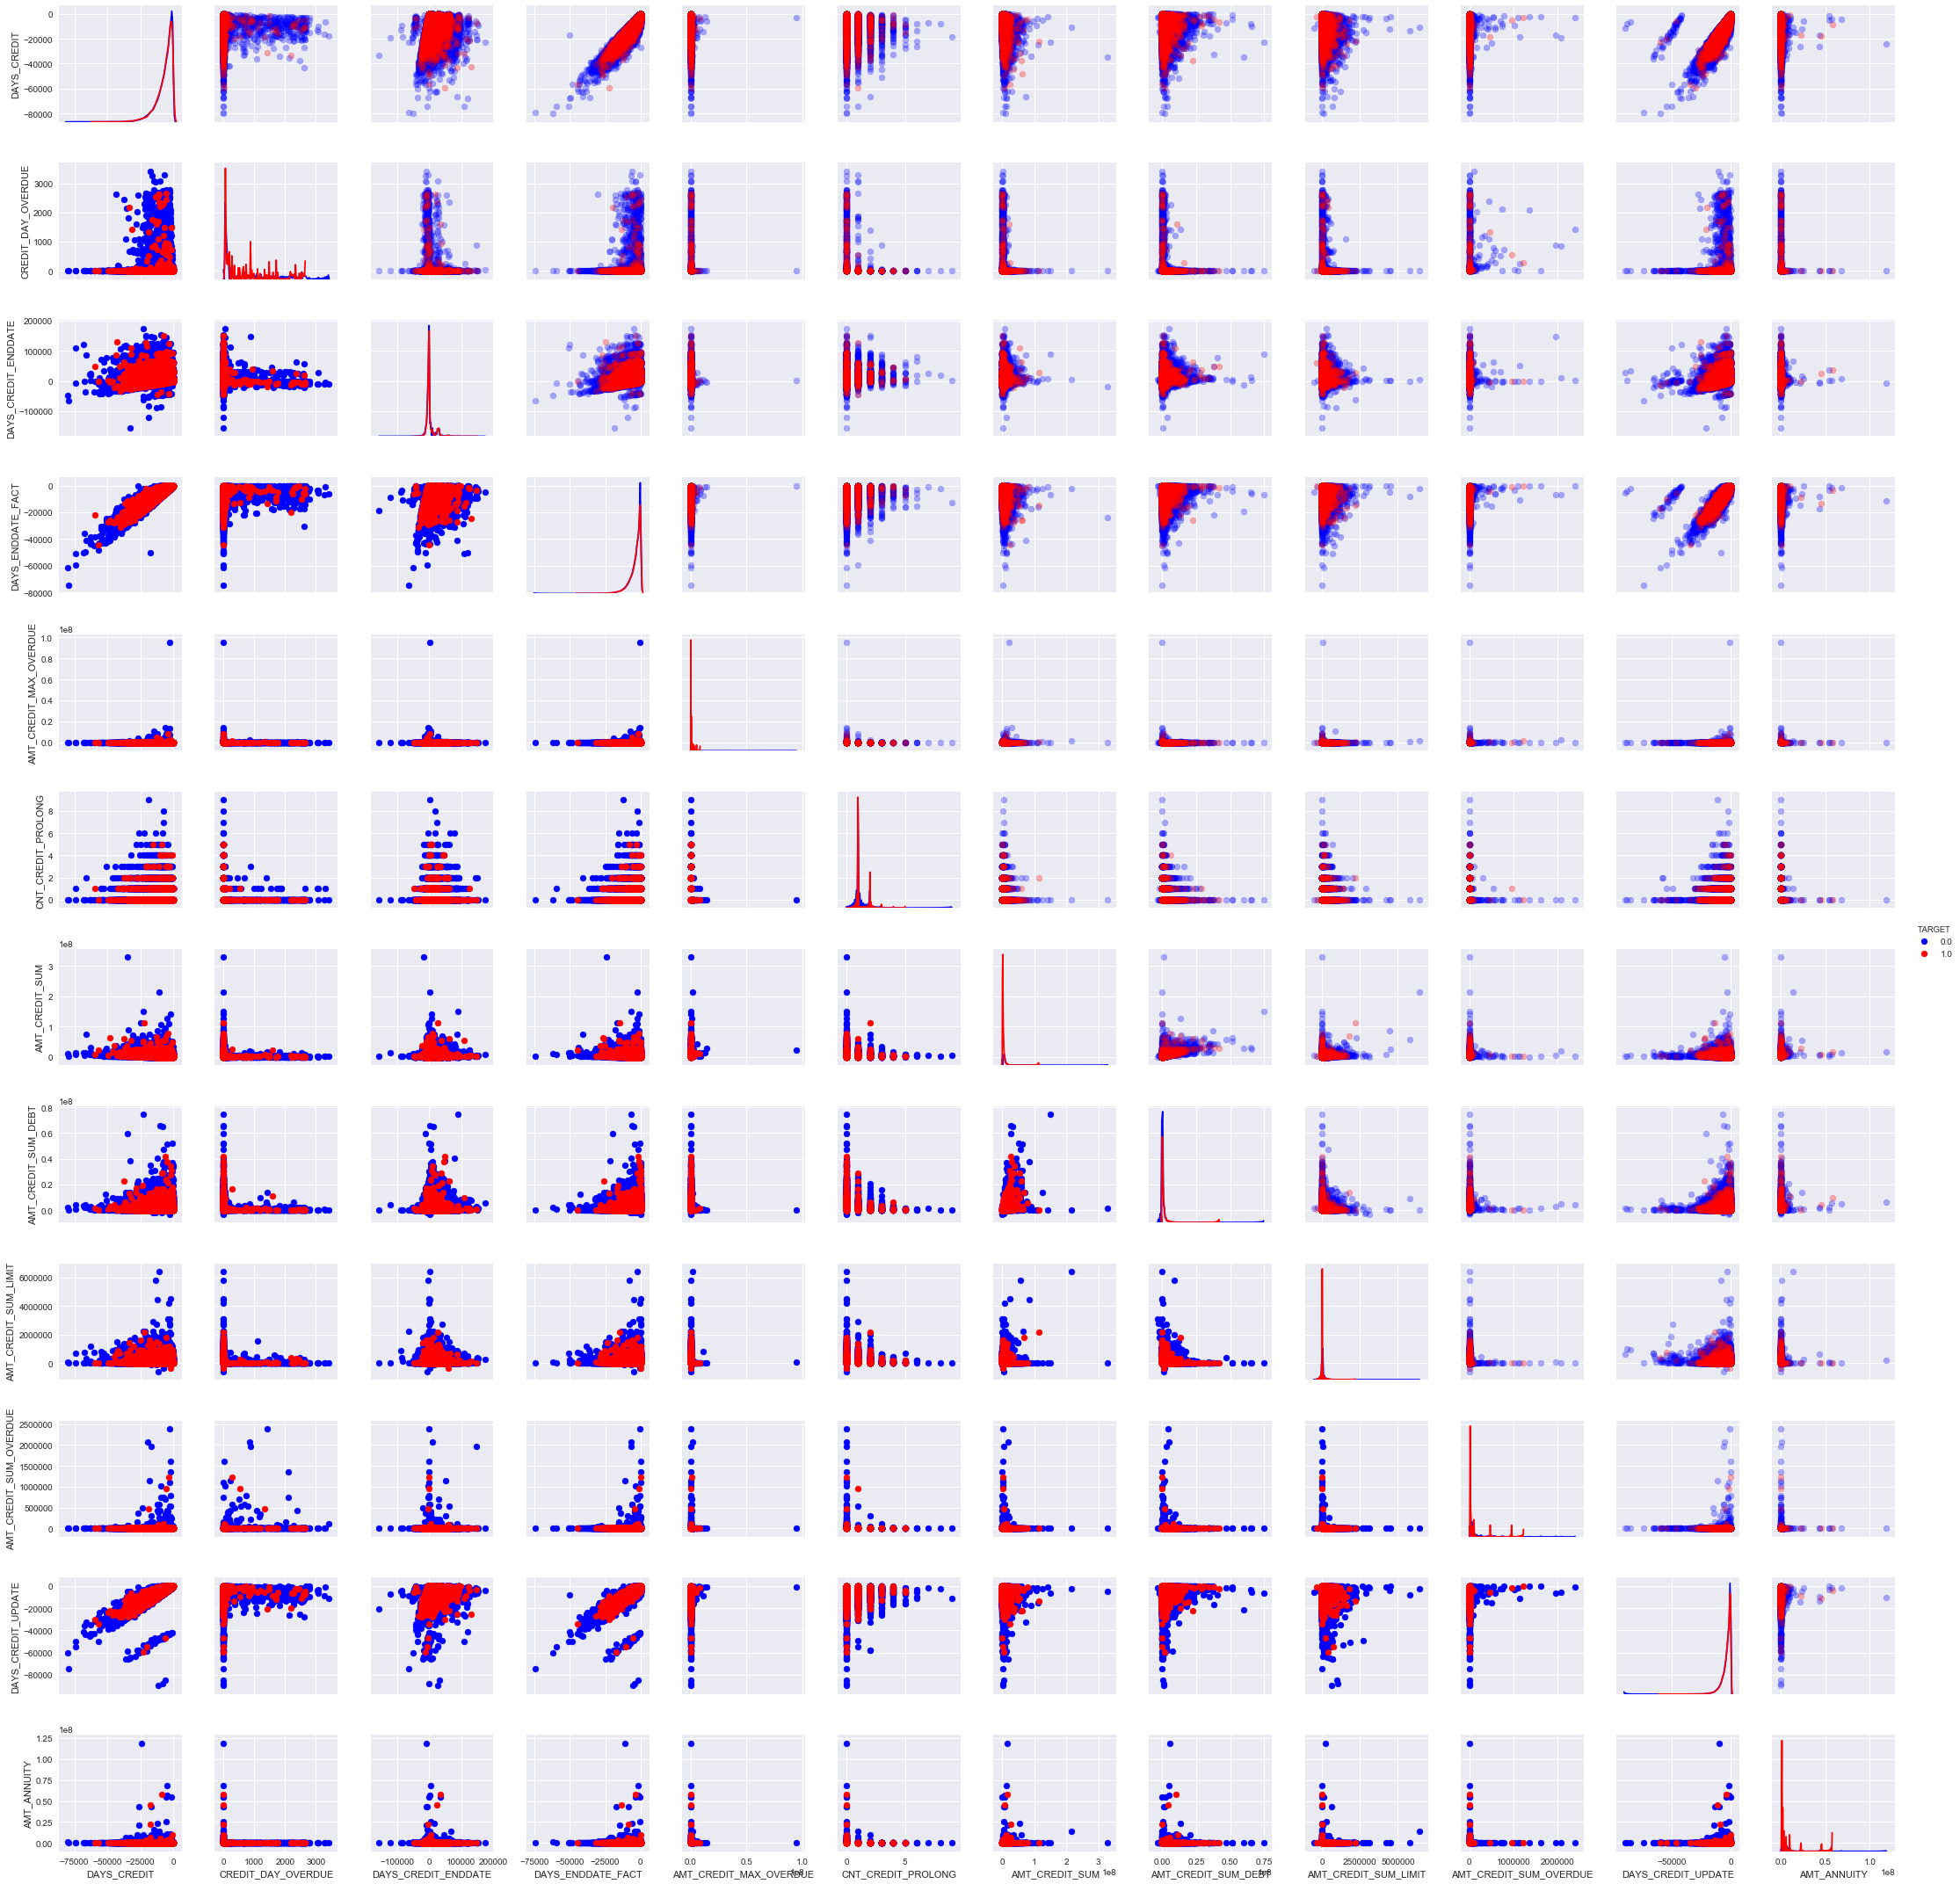

In [82]:
g = sns.PairGrid(bureau3,hue='TARGET', diag_sharey=False, vars=bureau2.columns.values[2:], palette={0:'Blue', 1:'Red'})
g.map_upper(plt.scatter, alpha = 0.3)
g.map_diag(sns.kdeplot)
g.map_lower(plt.scatter)
g.add_legend()

In [103]:
corr = bureau3.corr()[['TARGET']]

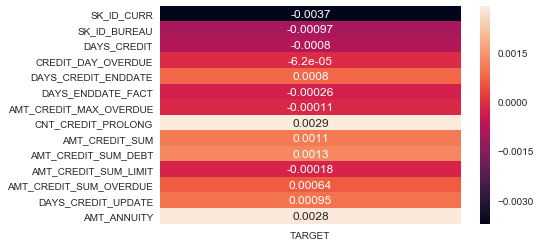

In [107]:
sns.heatmap(corr[:-1],annot=True)

In [ ]:
g = sns.PairGrid(bureau3,hue='TARGET', diag_sharey=False, vars=bureau2.columns.values[2:], palette={0:'Blue', 1:'Red'})
g.map_upper(plt.scatter, alpha = 0.3)
g.map_diag(sns.kdeplot)
g.map_lower(plt.scatter)
g.add_legend()

In [153]:
description[description['Table'] == 'bureau.csv'].values

array([['bureau.csv', 'SK_ID_CURR',
        'ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau ',
        'hashed'],
       ['bureau.csv', 'SK_BUREAU_ID',
        'Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)',
        'hashed'],
       ['bureau.csv', 'CREDIT_ACTIVE',
        'Status of the Credit Bureau (CB) reported credits', nan],
       ['bureau.csv', 'CREDIT_CURRENCY',
        'Recoded currency of the Credit Bureau credit', 'recoded'],
       ['bureau.csv', 'DAYS_CREDIT',
        'How many days before current application did client apply for Credit Bureau credit',
        'time only relative to the application'],
       ['bureau.csv', 'CREDIT_DAY_OVERDUE',
        'Number of days past due on CB credit at the time of application for related loan in our sample',
        nan],
       ['bureau.csv', 'DAYS_CREDIT_ENDDATE',
        'Remaining duration of CB credi

In [132]:
ccard_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.500,0.0,877.500,1700.325,1800.000,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.000,0.0,0.000,2250.000,2250.000,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.000,0.0,0.000,2250.000,2250.000,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.000,0.0,0.000,11795.760,11925.000,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.000,0.0,11547.000,22924.890,27000.000,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.815,270000,0.0,0.000,0.0,0.000,4449.105,3825.000,3825.000,80519.040,82773.315,82773.315,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.645,585000,67500.0,67500.000,0.0,0.000,14684.175,15750.000,15750.000,345433.860,351881.145,351881.145,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125,45000,45000.0,45000.000,0.0,0.000,0.000,264.690,0.000,44735.310,47962.125,47962.125,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.075,292500,90000.0,289339.425,0.0,199339.425,130.500,4093.515,4093.515,285376.410,286831.575,286831.575,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.195,225000,76500.0,111026.700,0.0,34526.700,6338.340,45000.000,45000.000,192793.275,197224.695,197224.695,3.0,9,0.0,6.0,38.0,Active,0,0


In [138]:
len(poscash_balance)
poscash_balance.set_index(['SK_ID_CURR','SK_ID_PREV']).sort_index()

10001358

MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE  \
SK_ID_CURR SK_ID_PREV                                                          
100001     1369693                -53             4.0                    0.0   
           1369693                -54             4.0                    1.0   
           1369693                -57             4.0                    4.0   
           1369693                -55             4.0                    2.0   
           1369693                -56             4.0                    3.0   
           1851984                -96             4.0                    2.0   
           1851984                -95             4.0                    1.0   
           1851984                -93             4.0                    0.0   
           1851984                -94             4.0                    0.0   
100002     1038818                -13            24.0                   18.0   
           1038818                -16            24.0                   21.0   
           1038818                -18            24.0                   23.0   
           1038818                -17            24.0                   22.0   
           1038818                 -5            24.0                   10.0   
           1038818                 -1            24.0                    6.0   
           1038818                -14            24.0                   19.0   
           1038818                -10            24.0                   15.0   
           1038818                 -6            24.0                   11.0   
           1038818                 -4            24.0                    9.0   
           1038818                -19            24.0                   24.0   
           1038818                -11            24.0                   16.0   
           1038818                -12            24.0                   17.0   
           1038818                 -9            24.0                   14.0   
           1038818                 -8            24.0                   13.0   
           1038818                 -7            24.0                   12.0   
           1038818                 -3            24.0                    8.0   
           1038818                 -2            24.0                    7.0   
           1038818                -15            24.0                   20.0   
100003     1810518                -23            12.0                   10.0   
           1810518                -25            12.0                   12.0   
...                               ...             ...                    ...   
456255     2073384                -21            24.0                   24.0   
           2631384                 -4            36.0                   14.0   
           2631384                -16            36.0                   26.0   
           2631384                 -9            36.0                   19.0   
           2631384                -10            36.0                   20.0   
           2631384                -23            36.0                   33.0   
           2631384                -17            36.0                   27.0   
           2631384                -11            36.0                   21.0   
           2631384                -18            36.0                   28.0   
           2631384                -15            36.0                   25.0   
           2631384                 -8            36.0                   18.0   
           2631384                -12            36.0                   22.0   
           2631384                 -3            36.0                   13.0   
           2631384                 -2            24.0                    0.0   
           2631384                -26            36.0                   36.0   
           2631384                -25            36.0                   35.0   
           2631384                 -6            36.0                   16.0   
           2631384     

In [142]:
inst_pmts

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295
7,1818599,111420,2.0,4,-968.0,-994.0,17862.165,17862.165
8,2723183,112102,0.0,14,-197.0,-197.0,70.740,70.740
9,1413990,109741,1.0,4,-570.0,-609.0,14308.470,14308.470


In [143]:
prev_app

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Y,1,NaN,NaN,NaN,Everyday expenses,Approved,-684,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Canceled,-14,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Canceled,-21,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-386,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-57,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
